loaded dataset shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no



info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

number of samples: 45211
number of features (including target): 17

missing values (if any)

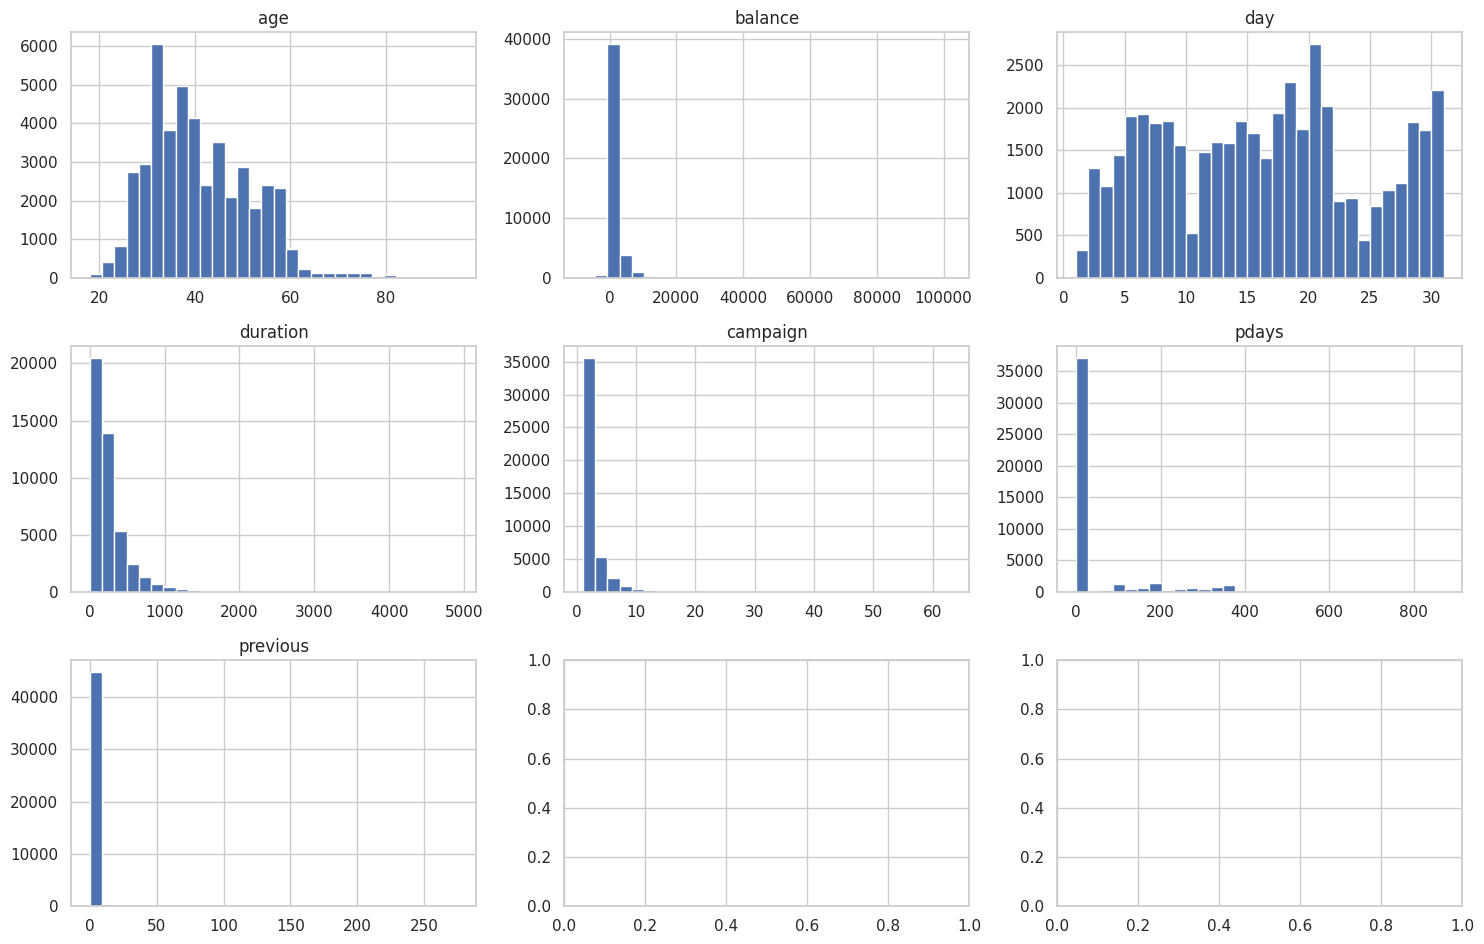

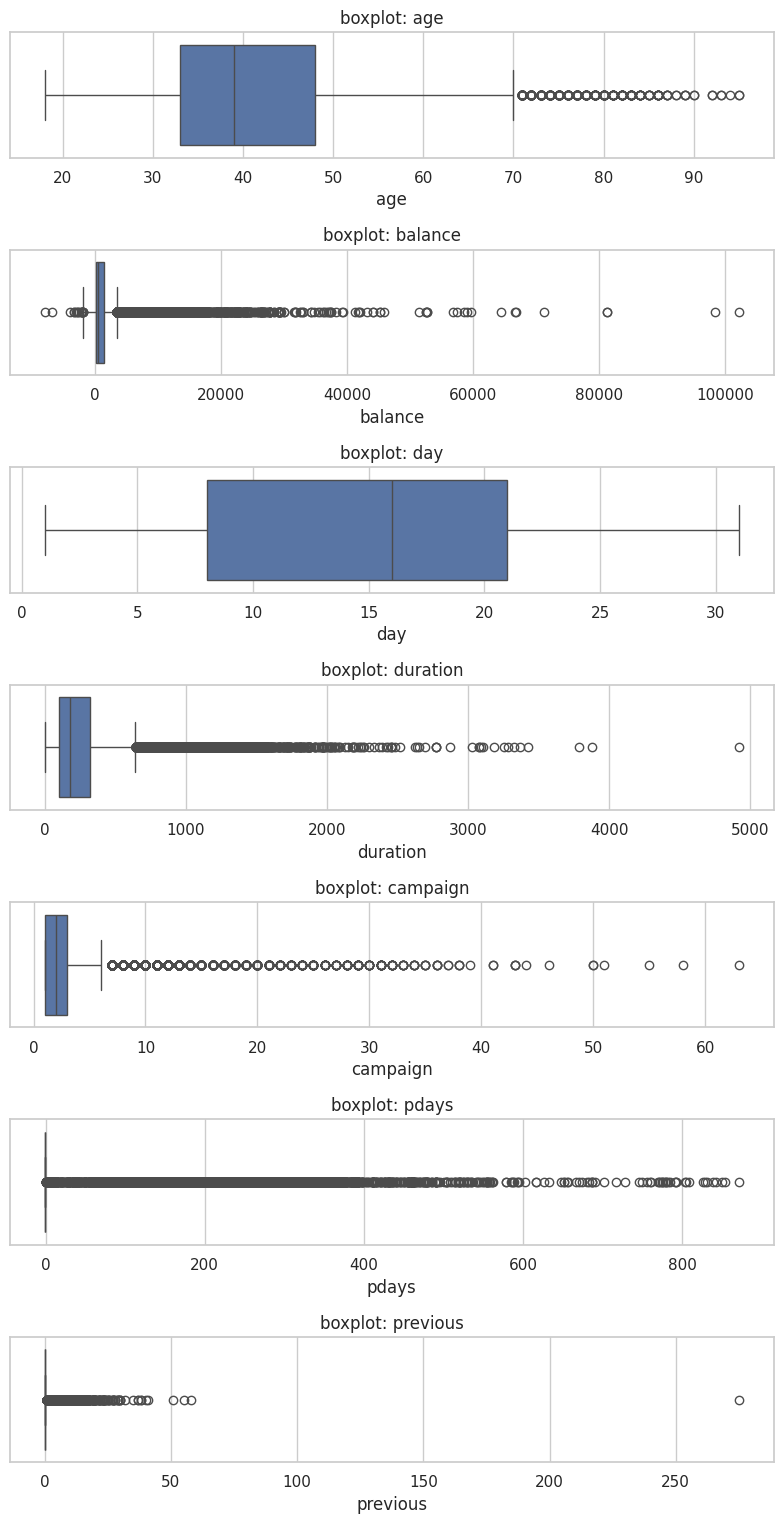


---- job ----
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
Name: count, dtype: int64

---- marital ----
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

---- education ----
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

---- default ----
default
no     44396
yes      815
Name: count, dtype: int64

---- housing ----
housing
yes    25130
no     20081
Name: count, dtype: int64

---- loan ----
loan
no     37967
yes     7244
Name: count, dtype: int64

---- contact ----
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

---- month ----
month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
N

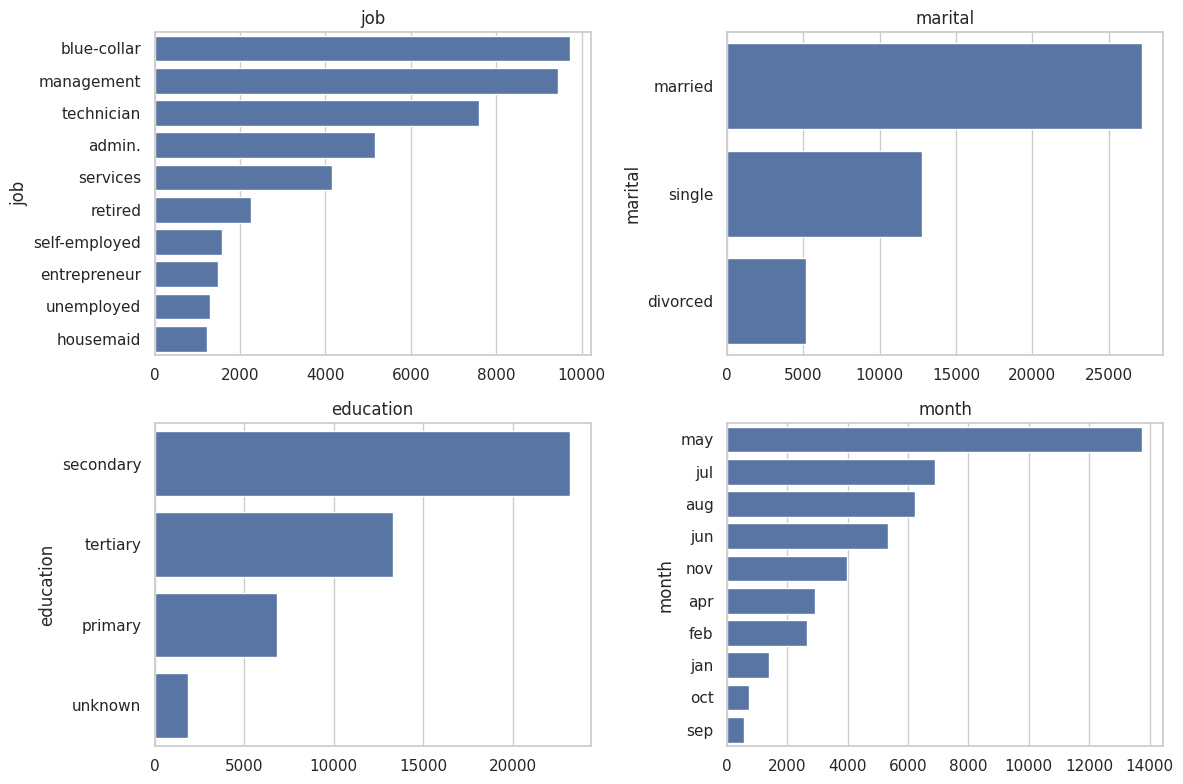

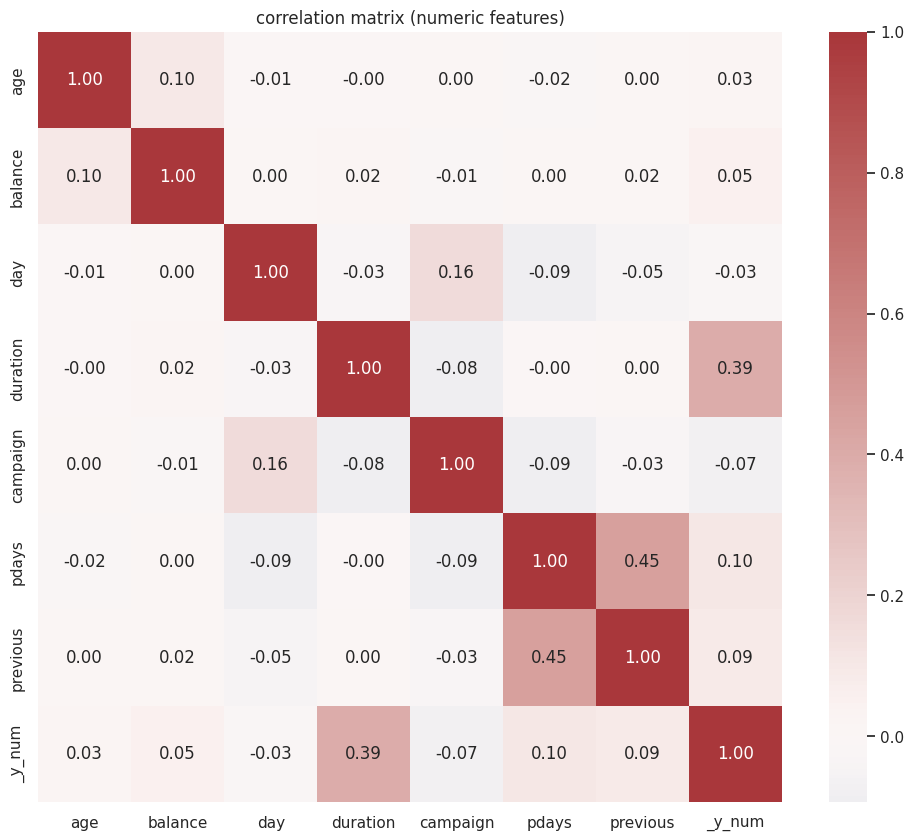

pdays unique values (top): pdays
-1      36954
 182      167
 92       147
 183      126
 91       126
Name: count, dtype: int64
pdays == 999 count: 0 (0.00% of rows)

Duration stats:
count   45211.000
mean      258.163
std       257.528
min         0.000
25%       103.000
50%       180.000
75%       319.000
max      4918.000
Name: duration, dtype: float64
num samples with duration>1000: 1058

transformed data shape: (45211, 51)
     age  balance    day  duration  campaign  pdays  previous  job_admin.  \
0  1.607    0.256 -1.298     0.011    -0.569 -0.411    -0.252       0.000   
1  0.289   -0.438 -1.298    -0.416    -0.569 -0.411    -0.252       0.000   
2 -0.747   -0.447 -1.298    -0.707    -0.569 -0.411    -0.252       0.000   
3  0.571    0.047 -1.298    -0.645    -0.569 -0.411    -0.252       0.000   
4 -0.747   -0.447 -1.298    -0.234    -0.569 -0.411    -0.252       0.000   

   job_blue-collar  job_entrepreneur  ...  month_jun  month_mar  month_may  \
0            0.000        

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

sns.set(style='whitegrid')

DATA_PATH = 'bank-full.csv'

if not os.path.exists(DATA_PATH):
    print(f"WARNING: {DATA_PATH} not found in working directory. Please place the CSV here or change DATA_PATH.")

try:
    df = pd.read_csv(DATA_PATH, sep=';')
except Exception as e:
    df = pd.read_csv(DATA_PATH)

print('loaded dataset shape:', df.shape)

display(df.head())
print('\ninfo:')
df.info()

print('\nnumber of samples:', df.shape[0])
print('number of features (including target):', df.shape[1])

missing = df.isna().sum()
missing = missing[missing > 0]
print('\nmissing values (if any):')
print(missing if not missing.empty else 'no missing values detected (check for special codes like 999)')

if 'y' in df.columns:
    print('\nTarget (y) distribution:')
    print(df['y'].value_counts())
    print('\nproportions:')
    print(df['y'].value_counts(normalize=True))

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()
if 'y' in cat_features:
    cat_features.remove('y')

print('numeric features:', numeric_features)
print('categorical features:', cat_features)

pd.options.display.float_format = '{:.3f}'.format
print(df[numeric_features].describe().T)

nnum = len(numeric_features)
cols = 3
rows = int(np.ceil(nnum / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.2*rows))
axes = axes.ravel()
for i, col in enumerate(numeric_features):
    ax = axes[i]
    df[col].hist(bins=30, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

selected = ['age'] + [c for c in numeric_features if c not in ['age']][:6]
fig, axes = plt.subplots(len(selected), 1, figsize=(8, 2.2*len(selected)))
for ax, col in zip(axes, selected):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'boxplot: {col}')
plt.tight_layout()
plt.show()

for col in cat_features:
    print('\n----', col, '----')
    vc = df[col].value_counts()
    print(vc.head(10))

cats_to_plot = ['job', 'marital', 'education', 'month']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, col in zip(axes, cats_to_plot):
    vc = df[col].value_counts().iloc[:10]
    sns.barplot(x=vc.values, y=vc.index, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

if 'y' in df.columns:
    df['_y_num'] = df['y'].map({'no': 0, 'yes': 1})

corr = df[numeric_features + (['_y_num'] if '_y_num' in df.columns else [])].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('correlation matrix (numeric features)')
plt.show()

if 'pdays' in df.columns:
    print('pdays unique values (top):', df['pdays'].value_counts().head())
    cnt_999 = (df['pdays'] == 999).sum()
    print('pdays == 999 count:', cnt_999, f'({100*cnt_999/len(df):.2f}% of rows)')

if 'duration' in df.columns:
    print('\nDuration stats:')
    print(df['duration'].describe())
    print('num samples with duration>1000:', (df['duration']>1000).sum())

ordinal_cols = []
one_hot_cols = cat_features.copy()
numeric_cols = numeric_features.copy()
for t in ['_y_num', 'y']:
    if t in numeric_cols:
        numeric_cols.remove(t)

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('cat', cat_pipeline, one_hot_cols)
])

X_trans = preprocessor.fit_transform(df)

oh = preprocessor.named_transformers_['cat']['onehot']
cat_feature_names = []
if hasattr(oh, 'get_feature_names_out'):
    cat_feature_names = oh.get_feature_names_out(one_hot_cols).tolist()
else:
    for col in one_hot_cols:
        vals = df[col].unique()
        for v in vals:
            cat_feature_names.append(f"{col}_{v}")

all_feature_names = numeric_cols + cat_feature_names
X_df = pd.DataFrame(X_trans, columns=all_feature_names)

print('\ntransformed data shape:', X_df.shape)

print(X_df.head())
print('\nany NaNs after transform?', X_df.isna().sum().sum())

if 'pdays' in df.columns:
    df['was_contacted_before'] = (df['pdays'] != 999).astype(int)
if 'duration' in df.columns:
    df['duration_log1p'] = np.log1p(df['duration'])

